# RTFeatureGenerator Demo

Demonstrates RT feature generation with pretrained and finetuned models.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
from dia_aspire_rescore.io import read_diann2
from dia_aspire_rescore.config import FineTuneConfig
from dia_aspire_rescore.finetuning import FineTuner
from dia_aspire_rescore.features import RTFeatureGenerator


In [2]:
psm_df_all = read_diann2("../data/raw/SYS026_RA957/DDA_SYSMHC_bynam/lib-base-result-first-pass.parquet")
psm_df_sample = psm_df_all[psm_df_all['fdr1_search1'] < 0.01].head(500).copy()
print(f"Loaded {len(psm_df_sample)} PSMs with RT information")


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/alphabase/psm_reader/psm_reader.py:342: UserWarning: Unknown modifications: {'Q(UniMod:1)'}. Precursors with unknown modifications will be removed.
  warnings.warn(


Loaded 500 PSMs with RT information


## Option A: Pretrained Model


In [3]:
config = FineTuneConfig()
finetuner = FineTuner(config)
finetuner.load_pretrained('generic')

rt_generator = RTFeatureGenerator(model_mgr=finetuner.model_manager)
print(f"Features: {rt_generator.feature_names}")


/Users/zshang/Projects/DIA-Aspire-rescore/.venv/lib/python3.11/site-packages/peptdeep/model/ms2.py:416: UserWarning: mask_modloss is deprecated and will be removed in the future. To mask the modloss fragments, the charged_frag_types should not include the modloss fragments.
  warnings.warn(


Features: ['rt_pred', 'delta_rt', 'abs_rt_delta', 'rt_ratio']


In [4]:
psm_df_pretrained = rt_generator.generate(psm_df_sample.copy())
print("RT Features (Pretrained):")
psm_df_pretrained[rt_generator.feature_names].head()


2025-12-06 02:52:22> Predicting RT ...


100%|██████████| 1/1 [00:00<00:00, 18.67it/s]

RT Features (Pretrained):


,rt_pred,delta_rt,abs_rt_delta,rt_ratio
1,0.678241,-0.120759,0.120759,0.848862
2,0.678241,-0.120753,0.120753,0.848868
13,0.428680,-0.155099,0.155099,0.734319
14,0.428680,-0.156283,0.156283,0.732832
15,0.428680,-0.155241,0.155241,0.734140


## Option B: Finetuned Model (Optional)


In [5]:
finetuner.train_rt(psm_df_sample)
rt_generator_finetuned = RTFeatureGenerator(model_mgr=finetuner.model_manager)

psm_df_finetuned = rt_generator_finetuned.generate(psm_df_sample.copy())
print("RT Features (Finetuned):")
psm_df_finetuned[rt_generator_finetuned.feature_names].head()


2025-12-06 02:52:22> 216 PSMs for RT model training/transfer learning
2025-12-06 02:52:22> Training with fixed sequence length: 0
[Training] Epoch=1, lr=2e-05, loss=0.17282718420028687
[Training] Epoch=2, lr=3e-05, loss=0.17256127297878265
[Training] Epoch=3, lr=4e-05, loss=0.17118500173091888
[Training] Epoch=4, lr=5e-05, loss=0.16962721943855286
[Training] Epoch=5, lr=6e-05, loss=0.16857093572616577
[Training] Epoch=6, lr=7e-05, loss=0.1671960949897766
[Training] Epoch=7, lr=8e-05, loss=0.1649489402770996
[Training] Epoch=8, lr=9e-05, loss=0.1624010056257248
[Training] Epoch=9, lr=0.0001, loss=0.15906111896038055
[Training] Epoch=10, lr=0.0001, loss=0.15538837015628815
[Training] Epoch=11, lr=9.972609476841367e-05, loss=0.15132597088813782
[Training] Epoch=12, lr=9.890738003669029e-05, loss=0.1475515067577362
[Training] Epoch=13, lr=9.755282581475769e-05, loss=0.14386151731014252
[Training] Epoch=14, lr=9.567727288213005e-05, loss=0.1394701600074768
[Training] Epoch=15, lr=9.33012701

100%|██████████| 1/1 [00:00<00:00, 23.06it/s]

RT Features (Finetuned):


,rt_pred,delta_rt,abs_rt_delta,rt_ratio
1,0.760250,-0.038750,0.038750,0.951502
2,0.760250,-0.038744,0.038744,0.951509
13,0.537158,-0.046622,0.046622,0.920138
14,0.537158,-0.047806,0.047806,0.918276
15,0.537158,-0.046764,0.046764,0.919914


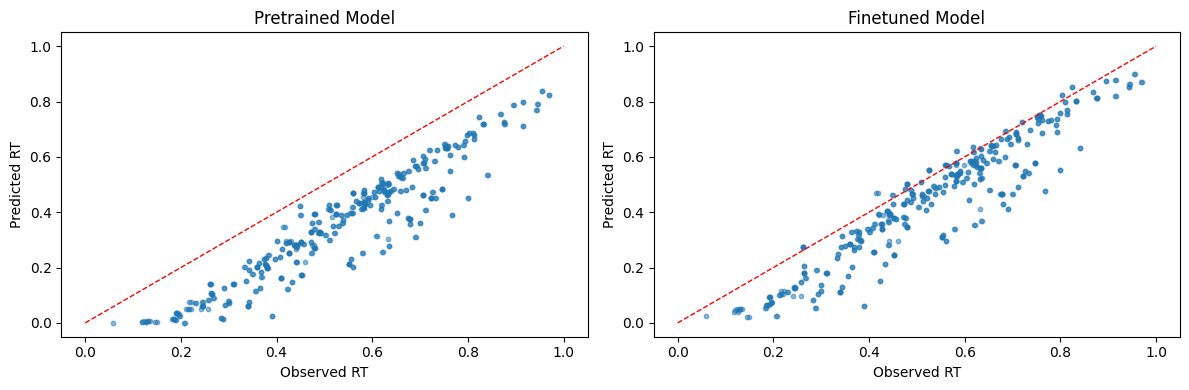

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].scatter(psm_df_pretrained['rt_norm'], psm_df_pretrained['rt_pred'], alpha=0.5, s=10)
axes[0].plot([0, 1], [0, 1], 'r--', lw=1)
axes[0].set_xlabel('Observed RT')
axes[0].set_ylabel('Predicted RT')
axes[0].set_title('Pretrained Model')

axes[1].scatter(psm_df_finetuned['rt_norm'], psm_df_finetuned['rt_pred'], alpha=0.5, s=10)
axes[1].plot([0, 1], [0, 1], 'r--', lw=1)
axes[1].set_xlabel('Observed RT')
axes[1].set_ylabel('Predicted RT')
axes[1].set_title('Finetuned Model')

plt.tight_layout()
plt.show()
